__Вводные данные:__

Дана динамика покупки пользователями платных подписок в мобильном приложении с марта по октябрь 2018 года. 1 октября 2018 года 
вышла новая версия приложения. С 10.10.18 по 12.10.18 пользователи могли оформить подписку со скидкой. 

__Задача__:

Необходимо проанализировать рост выручки.

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

In [3]:
sns.set_style('whitegrid')

In [4]:
dynamic_purchase = pd.read_excel('result.xlsx', sheet_name=0, names=['date', 'revenue'], dtype={'date': datetime})

In [5]:
# модификация данных
dynamic_purchase['month'] = dynamic_purchase['date'].apply(lambda x: calendar.month_name[x.month])

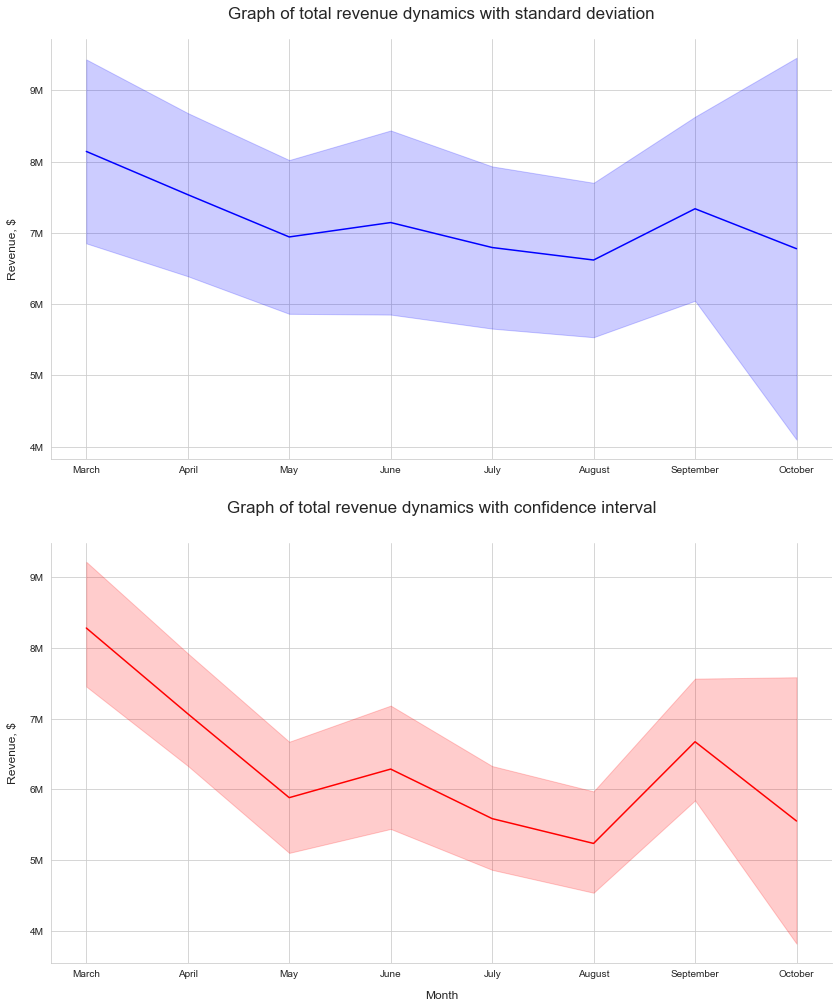

In [6]:
fig = plt.figure(figsize=(14, 17))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.despine()


sns.lineplot(data=dynamic_purchase, x='month', y='revenue', ci='sd', ax=ax1, color='blue')
sns.lineplot(data=dynamic_purchase, x='month', y='revenue', ax=ax2, color='red')


from matplotlib.ticker import FixedLocator
ax1.yaxis.set_major_locator(FixedLocator(ax1.get_yticks().tolist()))
ax1.set_yticklabels([f'{i}M' for i in range(3, 11)])
ax2.yaxis.set_major_locator(FixedLocator(ax2.get_yticks().tolist()))
ax2.set_yticklabels([f'{i}M' for i in range(3, 11)])

ax1.set_xlabel('', labelpad=12, fontsize=12)
ax1.set_ylabel('Revenue, $', labelpad=12, fontsize=12)
ax2.set_xlabel('Month', labelpad=12, fontsize=12)
ax2.set_ylabel('Revenue, $', labelpad=12, fontsize=12)

ax1.set_title('Graph of total revenue dynamics with standard deviation', pad=20, fontsize=17)
ax2.set_title('Graph of total revenue dynamics with confidence interval', pad=30, fontsize=17);

С первого взгляда (по графику со стандартным отклонением) можно заключить, что в выбранный период (относительно данных за март) наблюдалась медленная рецессия выручки с редким ее ростом в июне и сентябре. 
График с доверительным интервалом подтверждает данную гипотезу (значения выручки c апреля по октябрь не входят в ДИ марта). 

In [7]:
# расчет среднемесечной выручки
purchase_mean = dynamic_purchase.groupby('month', as_index=False, sort=False) \
                                .agg({'revenue': 'mean'}) \
                                .rename(columns={'revenue': 'mean_revenue'})

In [8]:
# фунцкии для расчёта ключевых параметров анализа выручки

# расчёт цепного/базисного прироста, где y2 - показатель за текущий месяц, y1 - показатель за предыдущий месяц/базисный показатель
increment = lambda y1, y2: round(y2 - y1, 2)

# расчёт цепного/базисного темпа роста
growth_rate = lambda y1, y2: round((y2 / y1) * 100, 2)

# расчёт цепного/базисного темпа прироста
increment_rate = lambda y1, y2: growth_rate(y1, y2) - 100


# расчёт среднего темпа роста, где n - количество месяцев, yn - показатель за текущий месяц, y0 - базисный показатель
mean_growth_rate = lambda n, y0, yn: round(pow((yn / y0), (1 / (n - 1))), 2) * 100
    
# расчёт среднего темпа прироста
mean_increment_rate = lambda n, y0, yn: mean_growth_rate(n, y0, yn) - 100

In [9]:
# расчёт параметров
pd.DataFrame({'period': [calendar.month_name[i] for i in range(4, 11)], 
              'chain_increment rate': [increment_rate(purchase_mean['mean_revenue'].values[i], purchase_mean['mean_revenue'].values[i + 1]) for i in range(7)],
              'basic_increment rate': [increment_rate(purchase_mean['mean_revenue'].values[0], purchase_mean['mean_revenue'].values[i]) for i in range(1, 8)]})

,period,chain_increment rate,basic_increment rate
0,April,-7.45,-7.45
1,May,-7.87,-14.74
2,June,2.91,-12.26
3,July,-4.91,-16.56
4,August,-2.58,-18.72
5,September,10.87,-9.88
6,October,-7.64,-16.77


Числовой расчет также подтверждает гипотезу о спаде выручки в данный период - она просела на 17 % относительно значений за март. Рост наблюдался лишь в июне и сентябре.

In [10]:
# выгрузка значений за октябрь и их модификация
new_version = (dynamic_purchase.loc[dynamic_purchase['date'].dt.month == 10])[['date', 'revenue']]
new_version['date'] = new_version['date'].apply(lambda x: x.day)
discont = (dynamic_purchase[(dynamic_purchase.date >= datetime(2018, 10, 10)) & (dynamic_purchase.date <= datetime(2018, 10, 12))])[['date', 'revenue']]
discont['date'] = discont['date'].apply(lambda x: x.day)

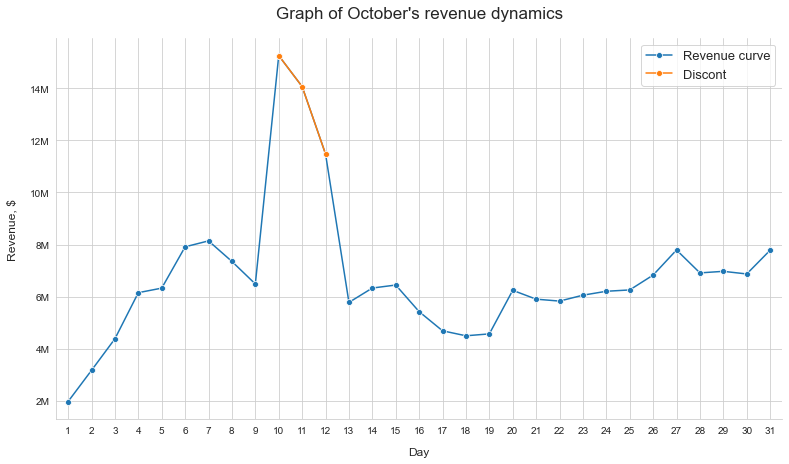

In [11]:
fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot()

sns.despine()


sns.lineplot(data=new_version, x='date', y='revenue', marker='o')
sns.lineplot(data=discont, x='date', y='revenue', marker='o')


from matplotlib.ticker import FixedLocator, MultipleLocator
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks().tolist()))
ax.set_yticklabels([f'{i}M' for i in range(0, 17, 2)])
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlim(xmin=0.5, xmax=31.5)

plt.xlabel('Day', labelpad=12, fontsize=12)
plt.ylabel('Revenue, $', labelpad=12, fontsize=12)

plt.legend(['Revenue curve', 'Discont'], fontsize=13)

plt.title("Graph of October's revenue dynamics", pad=20, fontsize=17);

Возможно, чтобы исправить ситуацию, была выпущена новая версия приложения, после чего действительно начал наблюдаться рост. Предложение приобрести подписку со скидкой также повлияло на ее (скачок выручки с 10 по 12 октября - максимальная выручка за период март-октябрь). Однако после его отмены - резкий спад и выход на относительно ровное плато динамики.